# Plan of the Chapter 

[1. Model building with Statsmodels](#section1)  
[2. Using Formulas as an Alternative](#section2)  
[3. The Correlation Matrix](#section3)  
[4. Feature Scaling](#section4)  
[5. Unstandardizing Coefficients](#section5)  
[6. Inspecting Standardized Coefficients](#section6)  
[7. Comparing Models by R-squared](#section7)  
[8. Discovering Interactions](#section8)  
[9. Testing Linear Versus Cubic Transformation](#section9)  
[10. Going for Higher-Degree Solutions](#section10)  
[11. Introducing Underfitting and Overfitting](#section11)  


In [153]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_boston
from sklearn import linear_model

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline 
from matplotlib import rc

rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
params = {'axes.labelsize': 12,
          'font.size': 14,
          'legend.fontsize':12,
          'xtick.labelsize': 12,
          'ytick.labelsize': 12,
          'text.usetex': True,
          'figure.figsize': (14, 8)
          }
plt.rcParams.update(params)

import seaborn as sns

**Boston**  dataset that tries to explain different house prices in the Boston of the 70s, given a series of statistics aggregated at the census zone level.

In [154]:
## Features
boston = load_boston()
dataset = pd.DataFrame(boston.data, columns=boston.feature_names)

## Target
dataset['target'] = boston.target
n_samples = len(dataset)

We will always work by keeping with us a series of informative variables, the number of observation and variable names, the input data matrix, and the response vector at hand.

In [155]:
## Data as arrays
features = dataset.columns[:-1]
X = dataset.ix[:, :-1]
y = dataset['target'].values

/Users/mzalaya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


<a id="section1"></a> 
# 1. Model building with Statsmodels


As a first step toward extending to more predictors the previously done analysis with Statsmodels, let's reload the necessary modules from the package (one working with matrices and the other with formulas).

Let's also prepare a suitable input matrix, naming it **Xc** after having it incremented by an extra column containing the bias vector (a constant variable having the unit value).

In [156]:
Xc = sm.add_constant(X)
linear_regression = sm.OLS(y, Xc)
fitted_model = linear_regression.fit()

/Users/mzalaya/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


After having fitted the preceding specified model, let's immediately ask for a summary.

In [157]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Fri, 12 Jul 2019   Prob (F-statistic):          6.72e-135
Time:                        23:45:12   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.4595      5.103      7.144      0.000      26.432      46.487
CRIM          -0.1080      0.033     -3.287      0.001      -0.173      -0.043
ZN             0.0464      0.014      3.382      0.001       0.019       0.073
INDUS          0.0206      0.061      0.334      0.738      -0.100       0.141
CHAS           2.6867      0.862      3.118      0.002       0.994       4.380
NOX          -17.7666      3.820     -4.651      0.000     -25.272     -10.262
RM             3.8099      0.418      9.116      0.000       2.989       4.631
AGE            0.0007      0.013      0.052      0.958      -0.025       0.027
DIS           -1.4756      0.199     -7.398      0.000      -1.867      -1.084
RAD            0.3060      0.066      4.613      0.000       0.176       0.436
TAX           -0.0123      0.004     -3.280      0.001      -0.020      -0.005
PTRATIO       -0.9527      0.131     -7.283      0.000      -1.210      -0.696
B              0.0093      0.003      3.467      0.001       0.004       0.015
LSTAT         -0.5248      0.051    -10.347      0.000      -0.624      -0.425
==============================================================================
Omnibus:                      178.041   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              783.126
Skew:                           1.521   Prob(JB):                    8.84e-171
Kurtosis:                       8.281   Cond. No.                     1.51e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The **adjusted R-squared** considers the complexity of the model and reports a much more realistic **R-squared measure**. 

Variables with a low **p-value** are good candidates for being removed from the model because there will probably be little proof that their estimated coefficient is different from zero.

In our example, being largely not significant (**p-value** major of 0.05), the **AGE** and **INDUS** variables are represented in the model by coefficients whose usefulness could be seriously challenged.

The condition number test **Cond. No.** is another statistic that now acquires a fresh importance under the light of a system of predictors. 
It signals numeric unstable results when trying an optimization based on matrix inversion. 
The cause of such instability is due to multicollinearity.

<a name="section2"></a>
# 2. Using formulas as an alternative

In [158]:
linear_regression = smf.ols(formula = 'target ~ CRIM + ZN + '
                                      'INDUS + CHAS + NOX + '
                                      'RM + AGE + DIS + RAD +'
                                      ' TAX + PTRATIO + B + LSTAT', data=dataset)

In [159]:
fitted_model = linear_regression.fit()

<a name="section3"></a>
# 3. The Correlation Matrix

To determine the manner and number of predictors affecting each other, the right tool is a correlation matrix, which, though a bit difficult to read when the number of the features is high, is still the most direct way to ascertain the presence of shared variance.

In [160]:
correlation_matrix = X.corr()
print(correlation_matrix)

             CRIM        ZN     INDUS      CHAS       NOX        RM       AGE  \
CRIM     1.000000 -0.200469  0.406583 -0.055892  0.420972 -0.219247  0.352734   
ZN      -0.200469  1.000000 -0.533828 -0.042697 -0.516604  0.311991 -0.569537   
INDUS    0.406583 -0.533828  1.000000  0.062938  0.763651 -0.391676  0.644779   
CHAS    -0.055892 -0.042697  0.062938  1.000000  0.091203  0.091251  0.086518   
NOX      0.420972 -0.516604  0.763651  0.091203  1.000000 -0.302188  0.731470   
RM      -0.219247  0.311991 -0.391676  0.091251 -0.302188  1.000000 -0.240265   
AGE      0.352734 -0.569537  0.644779  0.086518  0.731470 -0.240265  1.000000   
DIS     -0.379670  0.664408 -0.708027 -0.099176 -0.769230  0.205246 -0.747881   
RAD      0.625505 -0.311948  0.595129 -0.007368  0.611441 -0.209847  0.456022   
TAX      0.582764 -0.314563  0.720760 -0.035587  0.668023 -0.292048  0.506456   
PTRATIO  0.289946 -0.391679  0.383248 -0.121515  0.188933 -0.355501  0.261515   
B       -0.385064  0.175520 

At first glance, some high correlations appear to be present in the order of the absolute value of 0.70 between **TAX**, **NOX**, **INDUS**, and **DIS**. 
That's fairly explainable since **DIS** is the distance from employment centers, **NOX** is a pollution indicator, **INDUS** is the quota of non-residential or commercial buildings in the area, and **TAX** is the property tax rate. 
The right combination of these variables can well hint at what the productive areas are.

A faster, but less numerical representation is to build a heat map of the correlations.

In [161]:
## Matrix correlation
def visualize_correlation_matrix(data, hurdle=0.0):
    R = np.corrcoef(data, rowvar=0)
    R[np.where(np.abs(R) < hurdle)] = 0.0
    heatmap = plt.pcolor(R, cmap=mpl.cm.coolwarm, alpha=0.8)
    heatmap.axes.set_frame_on(False)
    heatmap.axes.set_yticks(np.arange(R.shape[0]) + 0.5, minor=False)
    heatmap.axes.set_xticks(np.arange(R.shape[1]) + 0.5, minor=False)
    heatmap.axes.set_xticklabels(features, minor=False)
    plt.xticks(rotation=90)
    heatmap.axes.set_yticklabels(features, minor=False)
    plt.tick_params(axis='both', which='both', bottom='off', 
                    top='off', left='off', right='off')
    plt.colorbar()
    plt.show()

/Users/mzalaya/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/mzalaya/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/mzalaya/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/mzalaya/anaconda3/lib/python3.7/site-packages/matplotlib/cbo

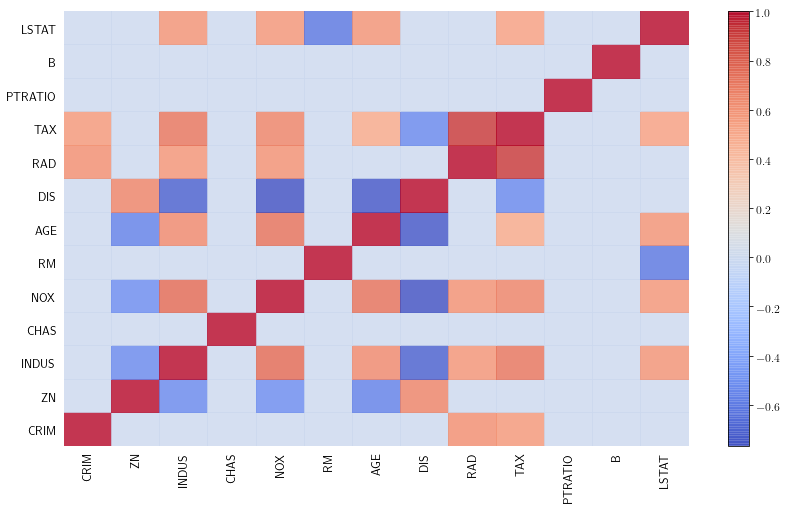

In [162]:
visualize_correlation_matrix(X, hurdle=0.5)

The heat map immediately reveals how **PTRATIO** and **B** are not so related to other predictors. 
Another intuition provided by the map is that a cluster of variables, namely **TAX**, **INDUS**, **NOX**, and **RAD**, is confirmed to be in strong linear association.

An even more automatic way to detect such associations (and figure out numerical problems in a matrix inversion) is to use eigenvectors. 

Eigenvectors are a very smart way to recombine the variance among the variables, creating new features accumulating all the shared variance. 

In [163]:
corr = np.corrcoef(X, rowvar=0)
eigenvalues, eigenvectors = np.linalg.eig(corr)
print(eigenvalues)

[6.12684883 1.43327512 1.24261667 0.85757511 0.83481594 0.65740718
 0.53535609 0.39609731 0.06350926 0.27694333 0.16930298 0.18601437
 0.22023782]


After extracting the eigenvalues, we print them in descending order and look for any element whose value is near to zero or small compared to the others.

Near zero values can represent a real problem for normal equations and other optimization methods based on matrix inversion.

Small values represent a high but not critical source of multicollinearity. 

If you spot any of these low values, keep a note of their index in the list (Python indexes start from zero). 

Using their index position in the list of eigenvalues, you can recall their specific vector from eigenvectors, which contains all the variable loadings—that is, the level of association with the original variables. 

In our example, we investigate the eigenvector at index 8. Inside the eigenvector, we notice values at index positions 2, 8, and 9, which are indeed outstanding in terms of absolute value.

In [164]:
print(eigenvectors[:,8])

[-0.0459523   0.08091897  0.25107654 -0.03592171 -0.04363045 -0.0455671
  0.03855068  0.01829854  0.63348972 -0.72023345 -0.02339805  0.00446307
 -0.02443168]


We now print the variables' names to know which ones contribute so much by their values to build the eigenvector.

In [165]:
print(features[2], features[8], features[9])

INDUS RAD TAX


Having found the multicollinearity culprits, what remedy could we use for such variables? Removal of some of them is usually the best solution and that will be carried out in an automated way when exploring how variable selection works in Chapter 6, Achieving Generalization. 


<a name="section4"></a>
# 4. Feature Scaling

 Working with different features requires more attention when estimating the coefficients because of their similarities which can cause a variance increase of the estimates. 

Multicollinearity between variables also has other drawbacks because it can also make matrix inversion (the matrix operation at the core of the normal equation coefficient estimation) very difficult, if not impossible, to achieve; such a problem is due to a mathematical limitation of the algorithm.
 
Anyway, though being quite resistant to problems that affect other approaches, its simplicity also makes it vulnerable to other common problems, such as the different scale present in each feature. In fact, some features in your data may be represented by measurements in units, some in decimals, and others in thousands, depending on what aspect of reality each feature represents. 

When it is the case that the features have a different scale, though the algorithm will be processing each of them separately, optimization will be dominated by the variables with the more extensive scale. Working in a space of dissimilar dimensions will require more iterations before convergence to a solution (and sometimes there might be no convergence at all).

The remedy is very easy; it is just necessary to put all the features on the same scale. Such an operation is called **feature scaling**. Feature scaling can be achieved through **standardization** or **normalization**. 

Normalization rescales all the values in the interval between zero and one (usually, but different ranges are also possible), whereas standardization operates by removing the mean and dividing by standard deviation to obtain a unit variance. 

In our case, standardization is preferable, both because it easily permits retuning the obtained standardized coefficients into their original scale and also because, by centering all the features at the zero mean, it makes the error surface more tractable by many machine learning algorithms, in a much more effective way than just rescaling the maximum and minimum of a variable. 


Let's try the algorithm, first using standardization based on the **Scikit-learn preprocessing module**.

In [166]:
from sklearn.preprocessing import StandardScaler
n_samples = len(dataset)
features = dataset.columns
standardization = StandardScaler()
Xst = standardization.fit_transform(X)
original_means = standardization.mean_
original_std = standardization.scale_
Xst = np.column_stack((Xst, np.ones(n_samples)))
y = dataset['target']

In the preceding code, we just standardized the variables using the **StandardScaler** class from **Scikit-learn**. This class can fit a data matrix, record its column means and standard deviations, and operate a transformation on itself, as well as on any other similar matrix, standardizing the column data. 

In [167]:
import random

def random_beta(p):
    return np.array([np.random.normal() for j in range(p)])

def hypothesis(Xdesign, beta):
    return np.dot(Xdesign, beta)

def loss(X, beta, y):
    return y - hypothesis(X, beta)
    
#def loss(Xdesign, beta, ytarget):
    #return y - np.dot(Xdesign, beta)

#def squared_loss(X, beta, y):
    #return loss(X, beta, y) ** 2

def squared_loss(Xdesign, beta, ytarget):
    return (ytarget - np.dot(Xdesign, beta))** 2 / (2 * len(ytarget))

def gradients(Xdesign, beta, ytarget):
    gradients = list()
    n = float(len(y))
    for j in range(len(beta)):
        gradients.append(np.sum(loss(Xdesign, beta, ytarget) * Xdesign[:, j]) / n)
    return gradients

def update(Xdesign, beta, ytarget, alpha=0.01):
    return [t - alpha * grad for t, grad in zip(beta, gradients(Xdesign, beta, ytarget))]
        

In [168]:
def Optimize(Xdesign, ytarget, alpha=0.01, tol=10**-12, iterations=20000):
    beta = random_beta(Xdesign.shape[1])
    path = list() #[]
    for k in range(iterations):
        SSL = np.sum(squared_loss(Xdesign, beta, ytarget))
        beta_new = update(Xdesign, beta, ytarget, alpha=alpha)
        new_SSL = np.sum(squared_loss(Xdesign, beta_new, ytarget))
        beta = beta_new
        if k >= 5 and (new_SSL - SSL <= tol and new_SSL >= -tol):
            path.append(new_SSL)
            return beta, path
        if k % (iterations /20) == 0:
            path.append(new_SSL)
        return beta, path

In [169]:
alpha =0.02
beta, path = Optimize(Xst, y, alpha, tol=10**-12, iterations =1000)
print("These are our final standardized coefficients: " + ", \ " .join(map(lambda x: "%0.4f" % x, beta)))


These are our final standardized coefficients: 1.0844, \ -0.3409, \ -0.0561, \ -1.4126, \ 0.5990, \ -0.6985, \ 0.0163, \ -0.6351, \ 0.1057, \ -1.4249, \ -0.5253, \ -0.7193, \ -0.9471, \ -0.0487


Observing the output, we now need a way to rescale the coefficients to their variables' characteristics and we will be able to report the gradient descent solution in unstandardized form. 

Another point to mention is our choice of alpha. After some tests, the value of 0.02 has been chosen for its good performance on this very specific problem. Alpha is the **learning rate** and during optimization it can be fixed or changeable, accordingly to a **line search** method, modifying its value in order to minimize as far as possible the cost function at each single step of the optimization process. In our example, we opted for a fixed learning rate and we had to look for its best value by trying a few optimization values and deciding on which minimized the cost in the minor number of iterations. 

<a name="section5"></a>
# 5. Unstandardizing Coefficients

Given a vector of standardized coefficients from a linear regression and its bias, we can recall the formulation of the linear regression, which is: 
 \HUGE$${y = \beta_0 + \sum_{j=1}^p x_j\beta_j}.$$

The previous formula, transforming the predictors using their mean and standard deviation, is actually equivalent (after a few calculations) to such an expression:

$$ y = \bigg(\hat \beta_0 - \sum_{j=1}^p \frac{\bar{x_j}\hat\beta_j}{\delta_j}\bigg)
+ 
\sum_{j=1}^p \frac{\hat\beta_j}{\delta_j}{x_j},$$
where $\bar{x}$ represents the original mean and $\delta$ the original standar deviation of the varibales.

By comparing the different parts of the two formulas (the first parenthesis and the second summation), we can calculate the bias and coefficient  equivalents when transforming a standardized coefficient into an unstandardized one. Without replicating all the mathematical formulas, we can quickly implement them into Python code and immediately provide an application showing how such calculations can transform gradient descent coefficients.


In [170]:
unstandardized_betas = beta[:-1] / original_std
unstandardized_bias = beta[-1] - np.sum((original_means / original_std) * beta[:-1])
print('%8s: %8.4f' % ('bias', unstandardized_bias))
for beta, feature_name in zip(unstandardized_betas, features):
          print('%8s: %8.4f' % (feature_name, beta))

    bias:  16.9413
    CRIM:   0.1262
      ZN:  -0.0146
   INDUS:  -0.0082
    CHAS:  -5.5672
     NOX:   5.1743
      RM:  -0.9951
     AGE:   0.0006
     DIS:  -0.3019
     RAD:   0.0121
     TAX:  -0.0085
 PTRATIO:  -0.2429
       B:  -0.0079
   LSTAT:  -0.1328


As an output from the previous code snippet, you will get a list of coefficients identical to our previous estimations with both Scikit-learn and Statsmodels.

<a name="section6"></a>
# 6. Inspecting Standardized Coefficients

By standardizing variables, we place them under a similar scale where a unit is the standard deviation of the variable itself. 

After standardization, larger coefficients can be interpreted as major contributions to establishing the result (a weighted summation, so the result will resemble larger weights more closely). Using standardized coefficients, we can therefore confidently rank our variables and spot those contributing less.

Let's proceed to an example using our Boston dataset. This time we will be using the **LinearRegression** method from **Scikit-learn** because we do not need to do a linear model for its statistical properties, but just a working model using a fast and scalable algorithm: 

In [171]:
linear_regression = linear_model.LinearRegression(normalize=False, fit_intercept=True)

In such an initialization, apart from the **fit_intercept** parameter that explicates the insertion of a bias into the design of model, the normalize option indicates whether we intend to rescale all the variables in the range between 0 and 1. Such a transformation is different from statistical standardization and we will omit it for the moment by setting it in a False state.

In [172]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
standardization = StandardScaler()
Stand_coef_linear_reg = make_pipeline(standardization, linear_regression)

In [173]:
Stand_coef_linear_reg

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

Besides the **StandardScaler** seen before, we also import from **Scikit-learn** the convenient **make_pipeline** wrapper, which allows us to establish a sequence of operations to be done automatically on our data before feeding it to the linear regression analysis. Now, the **Stand_coef_linear_reg** pipeline will execute a statistical standardization on data before regressing it, thus outputting standardized coefficients.

In [174]:
linear_regression.fit(X, y)
for coef, feature in sorted(zip(map(abs, linear_regression.coef_),
                                dataset.columns[:-1]), reverse=True):
    print("%6.3f\t %s"%(coef, feature))
    

17.767	 NOX
 3.810	 RM
 2.687	 CHAS
 1.476	 DIS
 0.953	 PTRATIO
 0.525	 LSTAT
 0.306	 RAD
 0.108	 CRIM
 0.046	 ZN
 0.021	 INDUS
 0.012	 TAX
 0.009	 B
 0.001	 AGE


As a first step, we output the coefficients of the regression on unstandardized data. As seen before, the output seems dominated by the huge coefficient of the **NOX** variable, which overlooks (with its absolute value of about 17.8) minor coefficients of 3.8 and less. However, we may question whether it could be so after also standardizing the variables.

In [175]:
Stand_coef_linear_reg.fit(X, y)
for coef, feature in sorted(zip(map(abs, Stand_coef_linear_reg.steps[1][1].coef_),
                           dataset.columns[:-1]), reverse=True):
    print("%6.3f \t %s"%(coef, feature))

 3.744 	 LSTAT
 3.104 	 DIS
 2.674 	 RM
 2.662 	 RAD
 2.077 	 TAX
 2.061 	 PTRATIO
 2.057 	 NOX
 1.082 	 ZN
 0.928 	 CRIM
 0.849 	 B
 0.682 	 CHAS
 0.141 	 INDUS
 0.019 	 AGE


Having all the predictors on a similar scale now, we can easily provide a more realistic interpretation of each coefficient. Clearly, it appears that a unit change has more impact when it involves the variables **LSTAT, DIS, RM, RAD, and TAX**. **LSTAT** is the percentage of lower status population, and this aspect explains its relevancy.

Using standardized scales has certainly pointed us at the most important variables but it is still not a complete overview of the predictive power of each variable because: 

Standardized coefficients represent how well the model works out its predictions because large coefficients heavily impact the resulting response: though having a large coefficient is certainly a hint of how important a variable is, it tells us just a part of the role that the variable plays in reducing the error of the estimates and in making our predictions more accurate.

Standardized coefficients can be ranked but their unit, though similar in scale, is somehow abstract (the standard deviation of each variable) and relative to the data at hand (so we shouldn't compare the standardized coefficients of different datasets because their standard deviations could be different)

One solution could be to integrate the importance estimate based on standardized coefficients, instead using some measure related to the error measure. 


<a name="section7"></a>
# 7. Comparing Models by R-squared

From a general point of view, we can evaluate a model by comparing how better it does in respect of simple mean, and that's the coefficient of determination, **R-square**.

In [176]:
from sklearn.metrics import r2_score
linear_regression = linear_model.LinearRegression(normalize=False, fit_intercept=True)

def r2_est(X, y):
    return r2_score(y, linear_regression.fit(X, y).predict(X))

print('Baseline R2:%0.3f' % r2_est(X, y))

Baseline R2:0.741


In [177]:
r2_impact = list()
for j in range(X.shape[1]):
    selection = [i for i in range(X.shape[1]) if i!=j]
    r2_impact.append(((r2_est(X, y) - r2_est(X.values[:, selection], y)), dataset.columns[j]))

for imp, varname in sorted(r2_impact, reverse=True):
                     print("%6.3f %s" %(imp, varname))

 0.056 LSTAT
 0.044 RM
 0.029 DIS
 0.028 PTRATIO
 0.011 NOX
 0.011 RAD
 0.006 B
 0.006 ZN
 0.006 CRIM
 0.006 TAX
 0.005 CHAS
 0.000 INDUS
 0.000 AGE


<a name="section8"></a>
# 8. Discovering Interactions

In [178]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
linear_regression = linear_model.LinearRegression(normalize=False, fit_intercept=True)
create_interactions = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

By degree parameter we define how many variables to put into the interaction, it being possible to have three or even more variables interact with each other.

In [179]:
def r2_est(X, y):
    return r2_score(y, linear_regression.fit(X, y).predict(X))

baseline = r2_est(X, y)
print("Baseline R2: %0.3f" % baseline)

Baseline R2: 0.741


In [180]:
Xi = create_interactions.fit_transform(X)
main_effects = create_interactions.n_input_features_

After recalling the baseline R-squared value, the code creates a new input data matrix using the fit_transform method, enriching the original data with the interaction effects of all the variables.

In [181]:
for k, effect in enumerate(create_interactions.powers_[(main_effects):]):
    # print(np.where(effect==1))
    # print(features[I])
    # print(features[effect])
    # break
    termA, termB = features[np.where(effect==1)[0]]
    # print(termA, termB)
    #termA, termB = features[effect==1]
    increment= r2_est(Xi[:, list(range(0, main_effects)) + [main_effects + k]], y) - baseline
    if increment > 0.01:
        print("Adding intearaction %8s * %8s R2: %5.3f" % (termA, termB, increment))

Adding intearaction     CRIM *     CHAS R2: 0.011
Adding intearaction     CRIM *       RM R2: 0.021
Adding intearaction       ZN *       RM R2: 0.013
Adding intearaction    INDUS *       RM R2: 0.038
Adding intearaction    INDUS *      DIS R2: 0.013
Adding intearaction      NOX *       RM R2: 0.027
Adding intearaction       RM *      AGE R2: 0.024
Adding intearaction       RM *      DIS R2: 0.018
Adding intearaction       RM *      RAD R2: 0.049
Adding intearaction       RM *      TAX R2: 0.054
Adding intearaction       RM *  PTRATIO R2: 0.041
Adding intearaction       RM *        B R2: 0.020
Adding intearaction       RM *    LSTAT R2: 0.064


In [182]:
Xi = X
Xi["interaction"] = X["RM"] * X["LSTAT"]
print("R2 of a model with RM*LSTAT interaction: %0.3f" % r2_est(Xi, y))

R2 of a model with RM*LSTAT interaction: 0.805


<a name="section9"></a>
# 9. Testing Linear Versus Cubic Transformation

In [183]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

linear_regression = linear_model.LinearRegression(normalize=False, fit_intercept=True)
create_cubic = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
create_quadratic =PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

linear_predictor = make_pipeline(linear_regression)
cubic_predictor =make_pipeline(create_cubic, linear_regression)
quadratic_predictor = make_pipeline(create_quadratic, linear_regression)

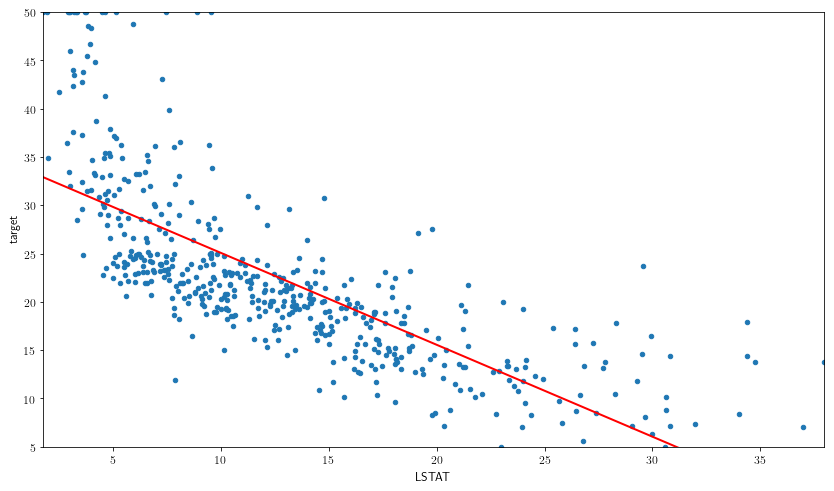

In [184]:
predictor = 'LSTAT'
x = dataset['LSTAT'].values.reshape((n_samples, 1))
xt = np.arange(0, 50, 0.1).reshape((np.int(50/0.1), 1))
x_range = [dataset[predictor].min(),dataset[predictor].max()]
y_range = [dataset['target'].min(),dataset['target'].max()]

scatter = dataset.plot(kind='scatter', x=predictor, y='target',
                       xlim=x_range, ylim=y_range)
regr_line = scatter.plot(xt, linear_predictor.fit(x,y).predict(xt),
                         '-', color='red', linewidth=2)

Our first fit is the linear one (a simple linear regression) and from the scatterplot we can notice that the line is not representing well the cloud of points relating to 'LSTAT' with the response; most likely we need a curve. Instead of testing a second degree transformation that will turn into a parabola, we immediately try a cubic transformation: using two bends, we should obtain a better fit.

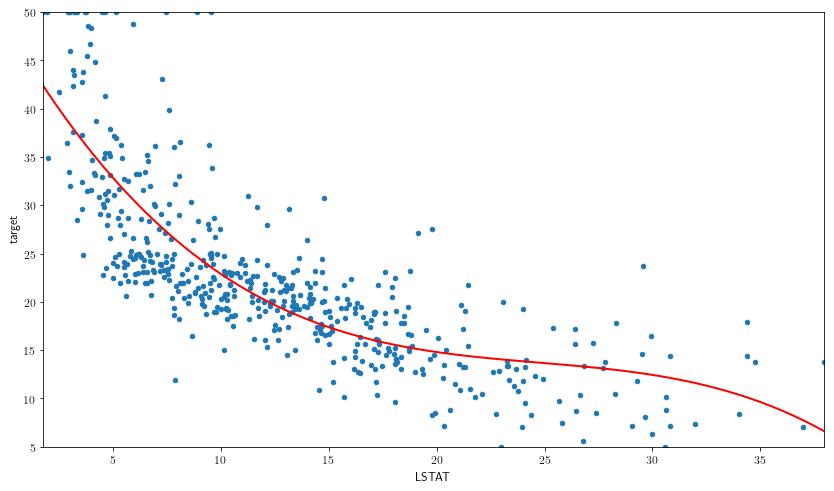

In [185]:
scatter = dataset.plot(kind='scatter', x=predictor, y='target', 
                         xlim=x_range, ylim=y_range)
regr_line = scatter.plot(xt, cubic_predictor.fit(x,y).predict(xt), 
                         '-', color='red', linewidth=2)


Our graphic check confirms that now we have a more credible representation of how 'LSTAT' and the response relate. We question whether we cannot do better using even higher-degree transformations.

<a name="section10"></a>
# 10. Going for Higher-Degree Solutions

To test a higher degree of polynomial transformations, we prepare a script that creates the expansion and reports its R-squared measure. We then try to plot the function with the highest degree in the series and have a look at how it fits the data points.

In [186]:
from sklearn.metrics import r2_score
for d in [1, 2, 3, 4, 5, 15]:
    create_poly = PolynomialFeatures(degree=d, interaction_only=False, include_bias=False)
    poly =make_pipeline(create_poly, StandardScaler(), linear_regression)
    model = poly.fit(x, y)
    print("R2 degree - %2i polynomial:%0.3f \t" %(d, r2_score(y, model.predict(x))))

R2 degree -  1 polynomial:0.544 	
R2 degree -  2 polynomial:0.641 	
R2 degree -  3 polynomial:0.658 	
R2 degree -  4 polynomial:0.673 	
R2 degree -  5 polynomial:0.682 	
R2 degree - 15 polynomial:0.695 	


Noticeably, there is a huge difference in the coefficient of determination between the linear model and the quadratic expansion (second-degree polynomial). The measure jumps from 0.544 to 0.641, a difference that increases up to 0.682 when reaching the fifth degree. Preceding to even higher degrees, the increment is not so astonishing, though it keeps on growing, reaching 0.695 when the degree is the fifteenth. As the latter is the best result in terms of coefficient of determination, having a look at the plot on the data cloud will reveal a not so smooth fit, as we can see with lower degrees of polynomial expansion.

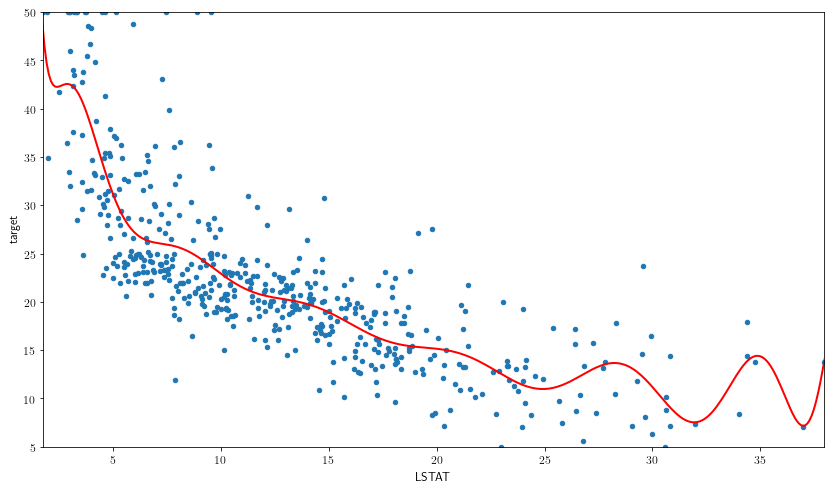

In [187]:
scatter = dataset.plot(kind='scatter', x=predictor, y='target', xlim=x_range, ylim=y_range)
regr_line = scatter.plot(xt, model.predict(xt), '-', color='red', linewidth=2)

Observing closely the resulting curve, you will surely notice how, by such a high degree, the curve tends strictly to follow the distribution of points, going erratic when the density diminishes at the fringes of the range of the predictors' values.

<a name="section11"></a>
# 11. Introducing Underfitting and Overfitting

Polynomial regression offers us the right occasion for starting to talk about **model complexity**. 
We have not explicitly tested it, but you may already have got the feeling that, by increasing the degree of the polynomial expansion, you are going to always reap better fits. 
We say more: the more variables you have in your model, the better, until you will have such a large number of betas, likely equal or almost equal to the number of your observations, that your predictions will be perfect.

Decaying performances due to over-parameterization (an excess of parameters to be learned by the model) is a problem of linear regression and of many other machine learning algorithms. 
The more parameters you add, the better the fit because the model will cease to intercept the rules and regularities of your data but will start, in such an embarrassment of riches, to populate the many available coefficients with all the erratic and erroneous information present in the data. 
In such a situation, the model won't learn general rules but it will just be memorizing the dataset itself in another form. 

This is called **overfitting**: fitting the data at hand so well that the result is far from being an extraction of the form of the data to draw predictions from; the result is just a mere memorization. 
On the other side, another problem is **underfitting**—that is, when you are using too few parameters for your prediction. The most straightforward example is fitting a non-linear relation using a simple linear regression; clearly, it won't match the curve bends and some of its predictions will be misleading.
